# -*- coding: utf-8 -*-
"""
Traducción de Stata → Python para los ejemplos II.5.9 e II.5.10 (Carol Alexander):
- Metodología Engle–Granger (FTSE y S&P500 en GBP)
- Cointegración (Johansen), VECM, y diagnósticos con tasas de interés UK

Requisitos:
    pip install pandas numpy matplotlib statsmodels arch openpyxl

Notas:
- Ajustá las rutas a tus archivos: Excel "Examples_II.5.xls" y dataset "UK_rates" (CSV/Excel).
- Este script sigue la lógica y los comentarios del .do de Stata provisto.
"""


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from arch.unitroot import DFGLS
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

In [3]:

# -----------------------------------------------------------------------------
# Helper functions
# -----------------------------------------------------------------------------

def dfgls_autolag_tstat(y, trend='n', max_lags=12):
    """DFGLS con regla secuencial tipo Ng–Perron (method='t-stat').
    Devuelve el objeto DFGLS y el número de rezagos elegido.
    trend: 'n' (no trend), 'c' (constante), 'ct' (const + tendencia)
    """
    df = DFGLS(y, trend={'n': 'n', 'c': 'c', 'ct': 'ct'}[trend], max_lags=max_lags, method='t-stat')
    return df, df.lags


def adf_with_lags(y, lags, trend='c'):
    """ADF con lags fijados para replicar dfuller ... , lags(k) regress de Stata.
    trend: 'n' (sin constante), 'c' (constante), 'ct' (const + tendencia).
    Retorna dict con estadístico, p-value y crítica.
    """
    res = adfuller(np.asarray(y), maxlag=lags, regression=trend, autolag=None)
    out = {
        'stat': res[0],
        'pvalue': res[1],
        'usedlag': res[2],
        'nobs': res[3],
        'crit': res[4],  # dict {'1%':..., '5%':..., '10%':...}
    }
    return out


def plot_series(df, cols, title):
    ax = df[cols].plot(figsize=(10, 4), grid=True)
    ax.set_title(title)
    plt.show()


def print_adf(label, res):
    print(f"ADF {label}: stat={res['stat']:.4f}, p={res['pvalue']:.4g}, lags={res['usedlag']}, nobs={res['nobs']}")
    print("  Critical values:")
    for k, v in res['crit'].items():
        print(f"    {k}: {v:.4f}")


# -----------------------------------------------------------------------------
# Ejemplo II.5.9: Engle–Granger con FTSE y S&P500 en GBP
# -----------------------------------------------------------------------------

# 1) Carga de Excel (ajustar ruta)
# En Stata: import excel "Examples_II.5.xls", sheet("EX_II.5.9(a)") cellrange(A1:E2737) firstrow
# En Python: usaremos read_excel y seleccionamos columnas por nombre.


In [4]:
path_xls = "Examples_II.5.xls"  # <-- AJUSTAR
sheet = "EX_II.5.9(a)"

ex = pd.read_excel(path_xls, sheet_name=sheet)
ex 
# Asumimos columnas: FTSE100, SP500, FX (como en Stata). Ajustar si difieren.
#assert set(['FTSE100', 'SP500', 'FX']).issubset(ex.columns), "Revisa nombres de columnas en el Excel."

,Date,FTSE100,S&P 500 ($),S&P500 (£),FX (£/$),FTSE100 (£),S&P500 (£).1,S&P 500 ($).1,Residuals,Unnamed: 9,...,Unnamed: 21,ADF(2) Regression,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
0,1996-01-02,3687.9,620.73,398.798587,0.642467,100.000000,100.000000,100.000000,0.041547,NaN,...,NaN,SUMMARY OUTPUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-01-03,3715.6,621.32,400.412451,0.644454,100.751105,100.404682,100.095049,0.561847,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996-01-04,3714.1,617.70,399.469702,0.646705,100.710431,100.168284,99.511865,0.656000,NaN,...,NaN,Regression Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996-01-05,3704.5,616.71,397.364691,0.644330,100.450121,99.640446,99.352375,0.696734,NaN,...,NaN,Multiple R,0.249576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996-01-08,3720.6,618.46,399.135205,0.645369,100.886683,100.084408,99.634302,0.880089,NaN,...,NaN,R Square,0.062288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2756,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2757,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2758,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2) Generación de variables como en Stata


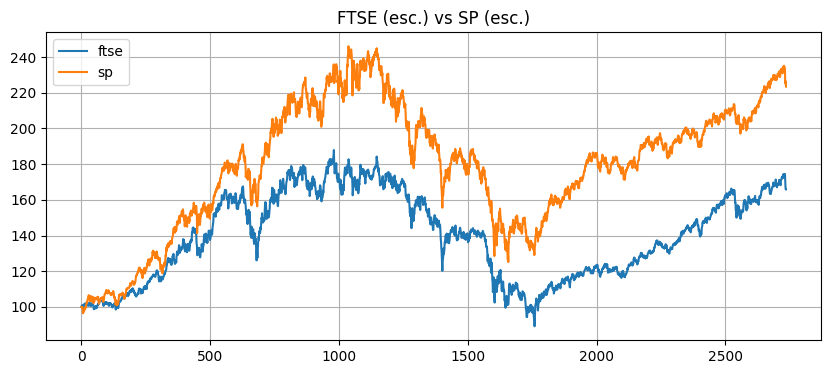

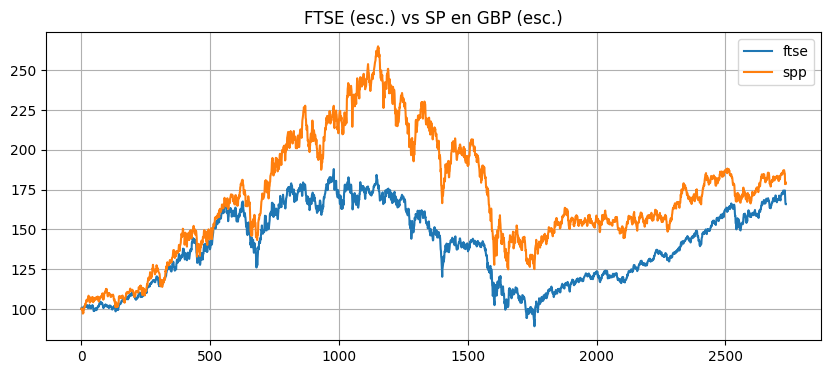

In [5]:
ex = ex.reset_index(drop=True)
ex['obs'] = np.arange(1, len(ex) + 1)
ex['ftse'] = ex['FTSE100'] / 36.879
ex['sp'] = ex['S&P 500 ($)'] / 6.2073
ex['sp_pounds'] = ex['S&P 500 ($)'] * ex['FX (£/$)']
ex['spp'] = ex['sp_pounds'] / 3.9879858

# Graficar series
plot_series(ex, ['ftse', 'sp'], 'FTSE (esc.) vs SP (esc.)')
plot_series(ex, ['ftse', 'spp'], 'FTSE (esc.) vs SP en GBP (esc.)')

In [6]:






# 3) Tests de raíz unitaria: DFGLS para sugerir lags y luego ADF con esos lags
# ftse (nivel)
dfgls_ftse, optlag_ftse = dfgls_autolag_tstat(ex['ftse'], trend='n', max_lags=12)
print(dfgls_ftse.summary())
res_adf_ftse = adf_with_lags(ex['ftse'], lags=optlag_ftse, trend='n')  # trend='n' ≈ noconstant
print_adf('ftse (nivel, noconstant)', res_adf_ftse)

# D.ftse (primera diferencia)
ex['D_ftse'] = ex['ftse'].diff()
dfgls_D_ftse, optlag_D_ftse = dfgls_autolag_tstat(ex['D_ftse'].dropna(), trend='n', max_lags=12)
print(dfgls_D_ftse.summary())
res_adf_D_ftse = adf_with_lags(ex['D_ftse'].dropna(), lags=optlag_D_ftse, trend='n')
print_adf('D.ftse (noconstant)', res_adf_D_ftse)

# spp (nivel)
dfgls_spp, optlag_spp = dfgls_autolag_tstat(ex['spp'], trend='n', max_lags=12)
print(dfgls_spp.summary())
res_adf_spp = adf_with_lags(ex['spp'], lags=optlag_spp, trend='n')
print_adf('spp (nivel, noconstant)', res_adf_spp)

# D.spp
en = ex.copy()
en['D_spp'] = ex['spp'].diff()
dfgls_D_spp, optlag_D_spp = dfgls_autolag_tstat(en['D_spp'].dropna(), trend='n', max_lags=12)
print(dfgls_D_spp.summary())
res_adf_D_spp = adf_with_lags(en['D_spp'].dropna(), lags=optlag_D_spp, trend='n')
print_adf('D.spp (noconstant)', res_adf_D_spp)

# 4) Regresión de cointegración (Engle–Granger paso 1): ftse ~ spp
X = add_constant(ex['spp'])  # incluye constante (como reg ftse spp)
model = OLS(ex['ftse'], X, missing='drop').fit()
print(model.summary())
ex['res'] = model.resid
plot_series(ex, ['res'], 'Residuos de cointegración (ftse ~ spp)')

# 5) ADF sobre los residuos sin constante (como: dfuller res, lags(3) noconstant regress)
res_adf_res = adf_with_lags(ex['res'].dropna(), lags=3, trend='n')  # noconstant
print_adf('res (ADF sin constante, lags=3)', res_adf_res)



ValueError: trend not understood

# -----------------------------------------------------------------------------
# Ejemplo II.5.10: Johansen y VECM con tasas UK
# -----------------------------------------------------------------------------

# Carga de tasas (ajustar ruta). Si tenés .dta de Stata, conviértelo a CSV/Excel.
# Esperamos columnas: mth1, mth2, mth3, mth6, mth9, mth12
# Tasas de rendimiento de bonos de uk a 1,2,3,6,9,12

Antes hay que testear en niveles y NO rechazar y luego testear en primeras diferencias y RECHAZAR, Esto es para ver que cada una es I(1)

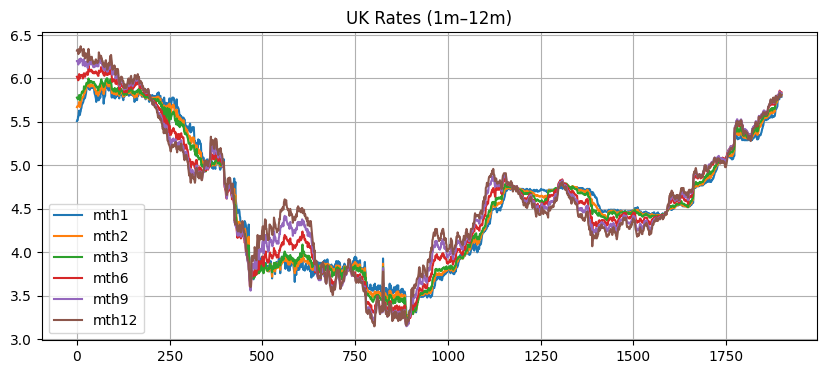

In [9]:
path_rates = "UK_rates.dta"  # <-- AJUSTAR
rates = pd.read_stata(path_rates)
rates = rates.reset_index(drop=True)
rates['obs'] = np.arange(1, len(rates) + 1)

cols_all = ['mth1', 'mth2', 'mth3', 'mth6', 'mth9', 'mth12']
assert set(cols_all).issubset(rates.columns), "Revisa columnas del archivo UK_rates"

plot_series(rates, cols_all, 'UK Rates (1m–12m)')

In [14]:
# 1) (comentado) Podrías testear raíces unitarias por serie como arriba (DFGLS/ADF)

# 2) Selección de lags (equivalente a varsoc en Stata)
# Usamos VAR.select_order (AIC, BIC, FPE, HQIC)
varsel = VAR(rates[cols_all].dropna()).select_order(maxlags=12)
print("Selección de rezagos (VAR):")
print(varsel.summary())

Selección de rezagos (VAR):
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -38.58      -38.56   1.762e-17      -38.57
1       -53.10      -52.98   8.650e-24      -53.06
2       -53.54     -53.31*   5.616e-24      -53.45
3       -53.62      -53.29   5.150e-24      -53.50
4       -53.67      -53.23   4.932e-24     -53.50*
5      -53.67*      -53.13  4.908e-24*      -53.47
6       -53.66      -53.01   4.963e-24      -53.42
7       -53.65      -52.89   5.021e-24      -53.37
8       -53.64      -52.78   5.055e-24      -53.32
9       -53.63      -52.66   5.099e-24      -53.28
10      -53.62      -52.55   5.149e-24      -53.23
11      -53.62      -52.44   5.175e-24      -53.18
12      -53.61      -52.32   5.237e-24      -53.13
--------------------------------------------------


### Ahora que tenemos los rezagos bajo algún criterio corremos el test de traza

 3) Johansen: número de relaciones de cointegración
 Stata: vecrank ... , trend(constant) max  (trace y max-eig con constante restringida en el EC)
 En statsmodels: coint_johansen(endog, det_order, k_ar_diff)
 det_order: -1: no det; 0: const en EC; 1: const en datos; 2: trend en datos, etc.

 Aca corremos los dos test el de traza y el de maximo autovalor

In [ ]:
k_ar_diff = 2  # ajustá acorde a selección de rezagos (lags en diferencias) aca usamos BIC por ejemplo
det_order = 0  # ~ trend(constant) de Stata

jres = coint_johansen(rates[cols_all].dropna(), det_order=det_order, k_ar_diff=k_ar_diff)

print("Johansen TRACE stats:", jres.lr1)
print("Johansen TRACE crit (90,95,99):\n", jres.cvt)
print("Johansen MAX-EIG stats:", jres.lr2)
print("Johansen MAX-EIG crit (90,95,99):\n", jres.cvm)

Johansen TRACE stats: [767.81710356 367.57861473 171.61352177  84.44083488  14.84609029
   3.21093818]
Johansen TRACE crit (90,95,99):
 [[ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]
Johansen MAX-EIG stats: [400.23848883 195.96509296  87.17268688  69.5947446   11.63515211
   3.21093818]
Johansen MAX-EIG crit (90,95,99):
 [[37.2786 40.0763 45.8662]
 [31.2379 33.8777 39.3693]
 [25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


Si el estadístico es mayor que el VC==> rechazo. Tengo que buscar NO rechazar para quedarme con el nivel de cointegracion, por lo tanto con el 95%. En ese caso me quedo 5 niveles de cointegracion, cuento desde 0.

In [ ]:
# 4) Estimar VECM si hay al menos una relación de cointegración
rank = 4  # como en Stata: vec ..., rank(4)
vecm = VECM(rates[cols_all].dropna(), k_ar_diff=k_ar_diff, coint_rank=rank, deterministic="co")  # 'co' ≈ constant in cointegration relation
vecm_res = vecm.fit()
print(vecm_res.summary())

# 5) Diagnósticos
# Autocorrelación (Ljung-Box sobre residuos por ecuación)
residuals = pd.DataFrame(vecm_res.resid, columns=[f"D_{c}" for c in cols_all])
for c in residuals.columns:
    lb = acorr_ljungbox(residuals[c], lags=[12], return_df=True)
    print(f"Ljung-Box(12) {c}: p-value={lb['lb_pvalue'].iloc[-1]:.4g}")

# Normalidad (Jarque–Bera por ecuación)
for c in residuals.columns:
    jb_stat, jb_p, skew, kurt = jarque_bera(residuals[c])
    print(f"Jarque–Bera {c}: JB={jb_stat:.3f}, p={jb_p:.4g}, skew={skew:.3f}, kurt={kurt:.3f}")

# Estabilidad (eigenvalues dentro del círculo unidad)
# statsmodels expone eigenvalues del companion; chequeo básico y gráfico
roots = vecm_res.roots
print("Máximo |root|:", np.max(np.abs(roots)))

fig, ax = plt.subplots(figsize=(5, 5))
unit_circle = plt.Circle((0, 0), 1.0, fill=False)
ax.add_artist(unit_circle)
ax.scatter(roots.real, roots.imag)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_title('VECM stability roots (inside unit circle)')
ax.set_aspect('equal', 'box')
plt.show()

# -----------------------------------------------------------------------------
# Caso bivariado: mth1 y mth12
# -----------------------------------------------------------------------------

cols_bi = ['mth1', 'mth12']
plot_series(rates, cols_bi, 'UK Rates: mth1 vs mth12')

# DFGLS por serie (tendencia/constante según naturaleza de tasas)
print(DFGLS(rates['mth1'].dropna(), trend='c', max_lags=12, method='t-stat').summary())
print(DFGLS(rates['mth12'].dropna(), trend='c', max_lags=12, method='t-stat').summary())

# Selección de lags bivariado
aic_bi = VAR(rates[cols_bi].dropna()).select_order(maxlags=12)
print(aic_bi.summary())

# Johansen (nivel de significancia se interpreta leyendo las tablas de crit)
jres_bi = coint_johansen(rates[cols_bi].dropna(), det_order=0, k_ar_diff=2)
print("TRACE stats:", jres_bi.lr1)
print("TRACE crit (90,95,99):\n", jres_bi.cvt)
print("MAX-EIG stats:", jres_bi.lr2)
print("MAX-EIG crit (90,95,99):\n", jres_bi.cvm)

# VECM bivariado con rank=1 y lags en diferencias = 2 (como en Stata)
vecm_bi = VECM(rates[cols_bi].dropna(), k_ar_diff=2, coint_rank=1, deterministic="co")
vecm_bi_res = vecm_bi.fit()
print(vecm_bi_res.summary())

# Diagnósticos
resid_bi = pd.DataFrame(vecm_bi_res.resid, columns=[f"D_{c}" for c in cols_bi])
for c in resid_bi.columns:
    lb = acorr_ljungbox(resid_bi[c], lags=[12], return_df=True)
    print(f"Ljung-Box(12) {c}: p-value={lb['lb_pvalue'].iloc[-1]:.4g}")
    jb_stat, jb_p, *_ = jarque_bera(resid_bi[c])
    print(f"Jarque–Bera {c}: p={jb_p:.4g}")

# Estabilidad
roots_bi = vecm_bi_res.roots
print("Máximo |root| (bivariado):", np.max(np.abs(roots_bi)))
fig, ax = plt.subplots(figsize=(5, 5))
ax.add_artist(plt.Circle((0, 0), 1.0, fill=False))
ax.scatter(roots_bi.real, roots_bi.imag)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_title('VECM bivariado: raíces de estabilidad')
ax.set_aspect('equal', 'box')
plt.show()

# -----------------------------------------------------------------------------
# Causalidad de Granger en el VECM bivariado
# En Stata se chequearon restricciones: [D_mth1]L1._ce1=0 y [D_mth1]LD.mth12=0, etc.
# En Python podemos hacer Wald tests sobre parámetros relevantes.
# statsmodels VECMResults expone params y cov_params; armamos un test sencillo.
# -----------------------------------------------------------------------------

import itertools
from numpy.linalg import inv

# Mapeo de nombres de parámetros
param_names = vecm_bi_res.params.index.tolist()
# Construimos un helper para wald_test sobre un conjunto de parámetros por nombre

def wald_test_by_names(res, names):
    params = res.params.values
    V = res.cov_params()
    # Seleccionar índices
    idx = [param_names.index(n) for n in names]
    R = np.zeros((len(idx), len(params)))
    for r, j in enumerate(idx):
        R[r, j] = 1.0
    r = np.zeros(len(idx))  # H0: esos params = 0
    W = float((R @ params - r).T @ inv(R @ V @ R.T) @ (R @ params - r))
    # Gl = número de restricciones
    from scipy.stats import chi2
    df = len(idx)
    pval = 1 - chi2.cdf(W, df)
    return W, df, pval

# Identificar nombres aproximados de los coeficientes que replican Stata
# Estructura típica de params en VECMResults: incluye coeficientes de EC (alpha), lags en diferencias y determinísticos.
# Buscamos por substring para encontrar _ce1 y LD.mth1/mth12
names = param_names

# H0: mth12 no causa a mth1 (en corto plazo y a través del EC): coef de _ce1 en ecuación D_mth1 y coef de LD.mth12 en ecuación D_mth1 son 0
names_h0_1 = [n for n in names if (n.startswith('D_mth1') and ('_ce1' in n or 'L1.D_mth12' in n))]
W1, df1, p1 = wald_test_by_names(vecm_bi_res, names_h0_1)
print("H0: mth12 NO causa a mth1 → Wald=%.3f, df=%d, p=%.4g" % (W1, df1, p1))

# H0: mth1 no causa a mth12: coef de _ce1 en ecuación D_mth12 y coef de LD.mth1 en ecuación D_mth12 son 0
names_h0_2 = [n for n in names if (n.startswith('D_mth12') and ('_ce1' in n or 'L1.D_mth1' in n))]
W2, df2, p2 = wald_test_by_names(vecm_bi_res, names_h0_2)
print("H0: mth1 NO causa a mth12 → Wald=%.3f, df=%d, p=%.4g" % (W2, df2, p2))

# -----------------------------------------------------------------------------
# Matrices α, β y Π = αβ'
# -----------------------------------------------------------------------------

alpha = vecm_res.alpha
beta = vecm_res.beta
Pi = alpha @ beta.T

print("alpha (ajuste):\n", alpha)
print("beta (cointegración):\n", beta)
print("Pi = alpha * beta':\n", Pi)

print("\nFin del script. Ajustá rutas y parámetros según tus datos.")
